# FloPy

## Creating a Simple MODFLOW 6 Model with Flopy

The purpose of this notebook is to demonstrate the Flopy capabilities for building a simple MODFLOW 6 model from scratch, running the model, and viewing the results.  This notebook will demonstrate the capabilities using a simple lake example.  A separate notebook is also available in which the same lake example is created for MODFLOW-2005 (flopy3_lake_example.ipynb).

### Setup the Notebook Environment

In [1]:
import sys
import os
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
flopy version: 3.2.13


In [2]:
# For this example, we will set up a model workspace.
# Model input files and output files will reside here.
workspace = os.path.join('data', 'mf6lake')
if not os.path.exists(workspace):
    os.makedirs(workspace)

### Create the Flopy Model Objects

We are creating a square model with a specified head equal to `h1` along all boundaries. The head at the cell in the center in the top layer is fixed to `h2`. First, set the name of the model and the parameters of the model: the number of layers `Nlay`, the number of rows and columns `N`, lengths of the sides of the model `L`, aquifer thickness `H`, hydraulic conductivity `k`

In [3]:
name = 'mf6lake'
h1 = 100
h2 = 90
Nlay = 10 
N = 101 
L = 400.0 
H = 50.0 
k = 1.0

One big difference between MODFLOW 6 and previous MODFLOW versions is that MODFLOW 6 is based on the concept of a simulation.  A simulation consists of the following:

* Temporal discretization (TDIS)
* One or more models (GWF is the only model supported at present)
* Zero or more exchanges (instructions for how models are coupled)
* Solutions

For this simple lake example, the simulation consists of the temporal discretization (TDIS) package (TDIS), a groundwater flow (GWF) model, and an iterative model solution (IMS), which controls how the GWF model is solved. 

In [4]:
# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(sim_name=name, exe_name='mf6', 
                             version='mf6', sim_ws=workspace)

# Create the Flopy temporal discretization object
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis', time_units='DAYS', nper=1, 
                                            perioddata=[(1.0, 1, 1.0)])

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(name)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, 
                           model_nam_file=model_nam_file)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', complexity='SIMPLE')

Now that the overall simulation is set up, we can focus on building the groundwater flow model.  The groundwater flow model will be built by adding packages to it that describe the model characteristics.

Define the discretization of the model. All layers are given equal thickness. The `bot` array is build from `H` and the `Nlay` values to indicate top and bottom of each layer, and `delrow` and `delcol` are computed from model size `L` and number of cells `N`. Once these are all computed, the Discretization file is built.

In [5]:
# Create the discretization package
bot = np.linspace(-H/Nlay, -H, Nlay) 
delrow = delcol = L/(N-1)
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nlay=Nlay, nrow=N, ncol=N,
                                               delr=delrow,delc=delcol,top=0.0,
                                               botm=bot)

In [6]:
# Create the initial conditions package
start = h1 * np.ones((Nlay, N, N))
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=start)

In [7]:
# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf', icelltype=1, k=k,
                                               save_flows=True)

In [8]:
# Create the constant head package.
# List information is created a bit differently for 
# MODFLOW 6 than for other MODFLOW versions.  The
# cellid (layer, row, column, for a regular grid)
# must be entered as a tuple as the first entry.
# Remember that these must be zero-based indices!
chd_rec = []
chd_rec.append(((0, int(N / 4), int(N / 4)), 90.0))
for layer in range(0, Nlay):
    for row_col in range(0, N):
        chd_rec.append(((layer, row_col, 0), 100.0))
        chd_rec.append(((layer, row_col, N - 1), 100.0))
        if row_col != 0 and row_col != N - 1:
            chd_rec.append(((layer, 0, row_col), 100.0))
            chd_rec.append(((layer, N - 1, row_col), 100.0))
chd = flopy.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', maxbound=len(chd_rec), 
                                               stress_period_data=chd_rec, save_flows=True)

In [9]:
# The chd package stored the constant heads in a structured
# array, also called a recarray.  We can get a pointer to the
# recarray for the first stress period (iper = 0) as follows.
iper = 0
ra = chd.stress_period_data.get_data(key=iper)
ra

rec.array([((0, 25, 25),  90.), ((0, 0, 0), 100.), ((0, 0, 100), 100.),
           ..., ((9, 100, 99), 100.), ((9, 100, 0), 100.),
           ((9, 100, 100), 100.)],
          dtype=[('cellid', 'O'), ('head', '<f8')])

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

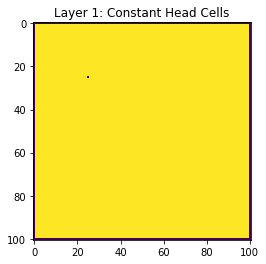

In [10]:
# We can make a quick plot to show where our constant
# heads are located by creating an integer array
# that starts with ones everywhere, but is assigned
# a -1 where chds are located
ibd = np.ones((Nlay, N, N), dtype=np.int)
for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [11]:
# Create the output control package
headfile = '{}.hds'.format(name)
head_filerecord = [headfile]
budgetfile = '{}.cbb'.format(name)
budget_filerecord = [budgetfile]
saverecord = [('HEAD', 'ALL'), 
              ('BUDGET', 'ALL')]
printrecord = [('HEAD', 'LAST')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc', saverecord=saverecord, 
                                            head_filerecord=head_filerecord,
                                            budget_filerecord=budget_filerecord,
                                            printrecord=printrecord)

In [12]:
# Note that help can always be found for a package
# using either forms of the following syntax
help(oc)
#help(flopy.mf6.modflow.mfgwfoc.ModflowGwfoc)

Help on ModflowGwfoc in module flopy.mf6.modflow.mfgwfoc object:

class ModflowGwfoc(flopy.mf6.mfpackage.MFPackage)
 |  ModflowGwfoc(model, loading_package=False, budget_filerecord=None, head_filerecord=None, headprintrecord=None, saverecord=None, printrecord=None, filename=None, pname=None, parent_file=None)
 |  
 |  ModflowGwfoc defines a oc package within a gwf6 model.
 |  
 |  Parameters
 |  ----------
 |  model : MFModel
 |      Model that this package is a part of.  Package is automatically
 |      added to model when it is initialized.
 |  loading_package : bool
 |      Do not set this parameter. It is intended for debugging and internal
 |      processing purposes only.
 |  budget_filerecord : [budgetfile]
 |      * budgetfile (string) name of the output file to write budget
 |        information.
 |  head_filerecord : [headfile]
 |      * headfile (string) name of the output file to write head information.
 |  headprintrecord : [columns, width, digits, format]
 |      * column

### Create the MODFLOW 6 Input Files and Run the Model

Once all the flopy objects are created, it is very easy to create all of the input files and run the model.

In [13]:
# Write the datasets
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model mf6lake...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd...
    writing package oc...


In [14]:
# Print a list of the files that were created
# in workspace
print(os.listdir(workspace))

['mf6lake.oc', 'mf6lake.lst', 'mf6lake.nam', 'mf6lake.dis', 'mf6lake.dis.grb', 'mf6lake.cbb', 'mf6lake.ims', 'mf6lake.chd', 'mf6lake.npf', 'mf6lake.ic', 'mf6lake.hds', 'mfsim.nam', 'mf6lake.tdis', 'mfsim.lst']


### Run the Simulation

We can also run the simulation from the notebook, but only if the MODFLOW 6 executable is available.  The executable can be made available by putting the executable in a folder that is listed in the system path variable.  Another option is to just put a copy of the executable in the simulation folder, though this should generally be avoided.  A final option is to provide a full path to the executable when the simulation is constructed.  This would be done by specifying exe_name with the full path.

In [15]:
# Run the simulation
success, buff = sim.run_simulation()
print('\nSuccess is: ', success)

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 19 2019 16:46:21 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
R

### Post-Process Head Results

Post-processing MODFLOW 6 results is still a work in progress.  There aren't any Flopy plotting functions built in yet, like they are for other MODFLOW versions.  So we need to plot the results using general Flopy capabilities.  We can also use some of the Flopy ModelMap capabilities for MODFLOW 6, but in order to do so, we need to manually create a SpatialReference object, that is needed for the plotting.  Examples of both approaches are shown below.

First, a link to the heads file is created with `HeadFile`. The link can then be accessed with the `get_data` function, by specifying, in this case, the step number and period number for which we want to retrieve data. A three-dimensional array is returned of size `nlay, nrow, ncol`. Matplotlib contouring functions are used to make contours of the layers or a cross-section.

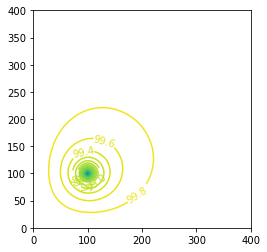

In [16]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
fname = os.path.join(workspace, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)
h = hds.get_data(kstpkper=(0, 0))
x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[0], np.arange(90,100.1,0.2))
plt.clabel(c, fmt='%2.1f')
plt.axis('scaled');

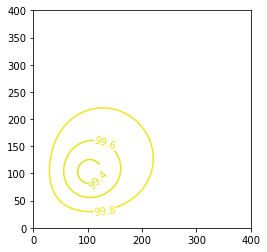

In [17]:
x = y = np.linspace(0, L, N)
c = plt.contour(x, y, h[-1], np.arange(90,100.1,0.2))
plt.clabel(c, fmt='%1.1f')
plt.axis('scaled');

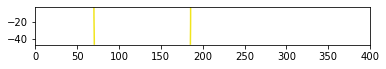

In [18]:
z = np.linspace(-H/Nlay/2, -H+H/Nlay/2, Nlay)
c = plt.contour(x, z, h[:,50,:], np.arange(90,100.1,.2))
plt.axis('scaled');

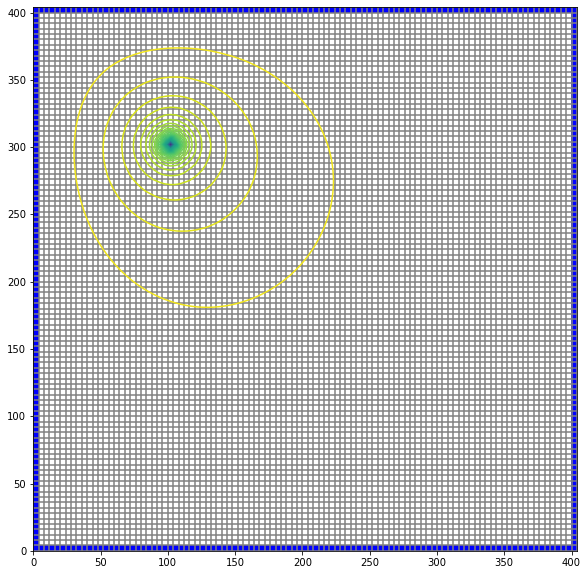

In [19]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax) 

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(h[0], levels=np.arange(90,100.1,0.2))

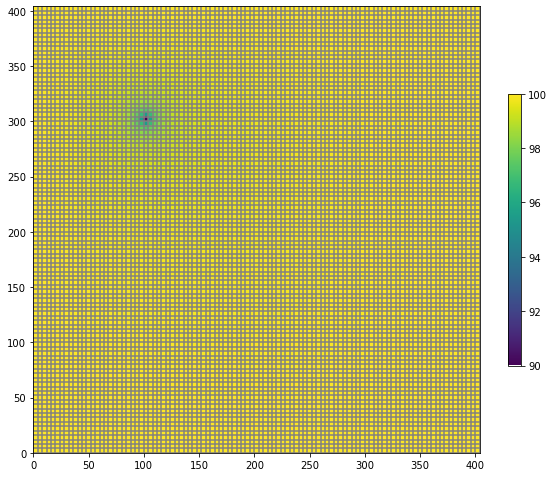

In [20]:
# We can also use the Flopy PlotMapView capabilities for MODFLOW 6
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

# Next we create an instance of the ModelMap class
modelmap = flopy.plot.PlotMapView(model=gwf, ax=ax)

# Then we can use the plot_grid() method to draw the grid
# The return value for this function is a matplotlib LineCollection object,
# which could be manipulated (or used) later if necessary.
quadmesh = modelmap.plot_ibound(ibound=ibd)
linecollection = modelmap.plot_grid()
pa = modelmap.plot_array(h[0])
cb = plt.colorbar(pa, shrink=0.5)

### Post-Process Flows

MODFLOW 6 writes a binary grid file, which contains information about the model grid.  MODFLOW 6 also writes a binary budget file, which contains flow information.  Both of these files can be read using Flopy capabilities.  The MfGrdFile class in Flopy can be used to read the binary grid file.  The CellBudgetFile class in Flopy can be used to read the binary budget file written by MODFLOW 6.

In [21]:
# read the binary grid file
fname = os.path.join(workspace, '{}.dis.grb'.format(name))
bgf = flopy.utils.mfgrdfile.MfGrdFile(fname)

# data read from the binary grid file is stored in a dictionary
bgf._datadict

OrderedDict([('NCELLS', 102010),
             ('NLAY', 10),
             ('NROW', 101),
             ('NCOL', 101),
             ('NJA', 689628),
             ('XORIGIN', 0.0),
             ('YORIGIN', 0.0),
             ('ANGROT', 0.0),
             ('DELR',
              array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.])),
             ('DELC',
              array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
                     4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       

In [22]:
# Information from the binary grid file is easily retrieved
ia = bgf._datadict['IA'] - 1
ja = bgf._datadict['JA'] - 1

In [23]:
# read the cell budget file
fname = os.path.join(workspace, '{}.cbb'.format(name))
cbb = flopy.utils.CellBudgetFile(fname, precision='double')
cbb.list_records()s

flowja = cbb.get_data(text='FLOW-JA-FACE')[0][0, 0, :]
chdflow = cbb.get_data(text='CHD')[0]

(1, 1, b'    FLOW-JA-FACE', 689628, 1, -1, 1, 1., 1., 1., b'', b'', b'', b'')
(1, 1, b'             CHD', 101, 101, -10, 6, 1., 1., 1., b'MF6LAKE         ', b'MF6LAKE         ', b'MF6LAKE         ', b'CHD             ')


In [24]:
# By having the ia and ja arrays and the flow-ja-face we can look at
# the flows for any cell and process them in the follow manner.
k = 5; i = 50; j = 50
celln = k * N * N + i * N + j
print('Printing flows for cell {}'.format(celln + 1))
for ipos in range(ia[celln] + 1, ia[celln + 1]):
    cellm = ja[ipos]  # change from one-based to zero-based
    print('Cell {} flow with cell {} is {}'.format(celln + 1, cellm + 1, flowja[ipos]))

Printing flows for cell 56106
Cell 56106 flow with cell 45905 is -0.0002858449337963975
Cell 56106 flow with cell 56005 is -0.025019694309449392
Cell 56106 flow with cell 56105 is -0.025019694309449392
Cell 56106 flow with cell 56107 is 0.025058524820593675
Cell 56106 flow with cell 56207 is 0.02505852482066473
Cell 56106 flow with cell 66307 is 0.00033448625827077195
